In [ ]:
## 1. Transform data to record format
## First dataset from http://www.robots.ox.ac.uk/~vgg/data/scenetext/
## This method failed, because 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import numpy as np
import scipy.io as sio
import gzip
from zipfile import ZipFile
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')
from datasets import sythtextprovider
import tensorflow as tf
import skimage.io as skio
#tf.InteractiveSession()
from PIL import Image
import re
import os
slim = tf.contrib.slim
tf.__version__
#from image_processing2 import *
from processing import txt_preprocessing
import tf_extended as tfe
from processing import tf_image
from nets import txtbox_300
import tf_utils
from nets import custom_layers
import load_batch

In [2]:
isess = tf.InteractiveSession()

In [3]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    print [ymin,xmin,ymax,xmax]
    skio.imshow(image)
    skio.show()

file_path: ../data/sythtext/*.tfrecord
1.20944 -1.01833
(300, 300, 3)
1.18963 -0.994334
[[42, 65, 67, 80, 232, 42, 58, 142], [113, 120, 5, 15, 1, 162, 164, 14], [63, 89, 90, 105, 247, 58, 75, 195], [153, 162, 31, 44, 30, 184, 194, 70]]


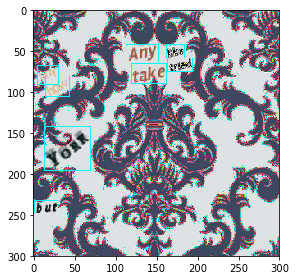

[[42, 59, 61, 70, 184, 267, 42, 54, 117], [117, 123, 11, 21, 8, 69, 164, 166, 20], [58, 77, 78, 89, 195, 294, 54, 67, 156], [155, 164, 37, 49, 36, 104, 185, 195, 74]]


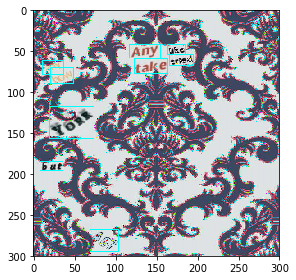

1.24576 -1.02971
(300, 300, 3)
1.19789 -0.989671
[[-21], [133], [41], [185]]


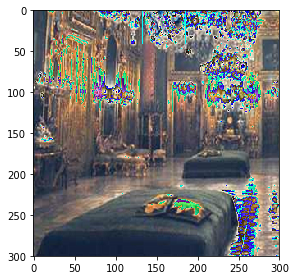

[[41, 61, 96], [0, 1, 79], [60, 72, 134], [26, 24, 104]]


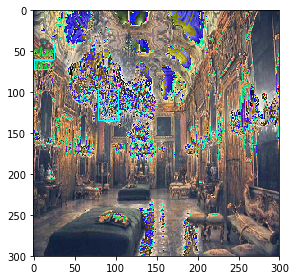

1.20593 -1.05422
(300, 300, 3)
1.19183 -1.05231
[[235], [-11], [256], [74]]


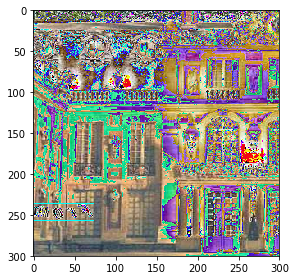

[[227], [253], [246], [293]]


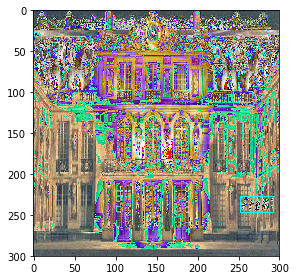

1.18431 -0.94902
(300, 300, 3)
1.19789 -0.971347
[[157, 229, -18], [146, 134, 118], [203, 283, 28], [214, 215, 166]]


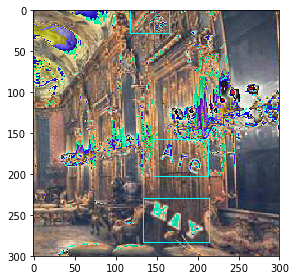

[[152, 9, 205, 4, 1, 19], [231, 28, 226, 44, 232, 219], [186, 39, 246, 15, 37, 55], [259, 53, 260, 63, 252, 239]]


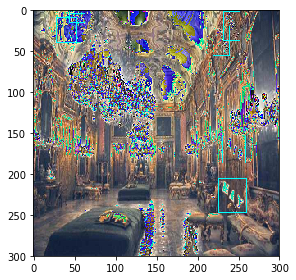

1.18431 -0.952941
(300, 300, 3)
1.34608 -1.06103
[[251, 262, 226, 140, 152, 71, 253], [212, 210, 133, 256, 260, 8, 136], [259, 270, 234, 148, 159, 109, 265], [225, 227, 162, 280, 279, 49, 167]]


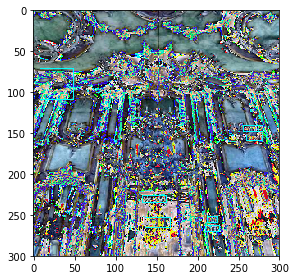

[[251, 262, 226, 140, 152, 71, 253], [74, 72, 137, 19, 20, 250, 132], [259, 270, 234, 148, 159, 109, 265], [87, 89, 166, 43, 39, 291, 163]]


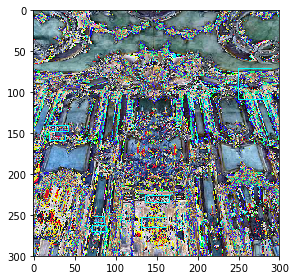

In [4]:
#out_shape = [700,700]
with tf.Graph().as_default(): 
    # build a net
    text_net = txtbox_300.TextboxNet()
    text_shape = text_net.params.img_shape
    #print 'text_shape ' +  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/sythtext/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes,height,width] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox','height','width'])

    
    image_train, tlabels, tbboxes,num = \
        txt_preprocessing.preprocess_image(image,  glabels,gbboxes,
                                        [300,300],data_format = 'NHWC', is_training=True)
    image_test, elabels, ebboxes, bbox_img,num = \
        txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                        [300,300],data_format = 'NHWC',is_training=False)
    batch_image = slim.batch_norm(image_train)
    #scala_image = tf.cast(image_train, tf.uint8)
    
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            for i in xrange(5):
                image_, batch_image_,image_test_,bbox_,test_box= sess.run([image_train,batch_image,image_test,tbboxes,ebboxes])
                #image_ = image_*255
                print image_.max(),image_.min()
                print image_.shape
                print image_test_.max(), image_test_.min()
                image_ = image_ * 255.
                image_ = image_.astype(np.uint8)
                visualize_bbox(image_, bbox_)
                image_test_ = image_test_ * 255.
                image_test_ = image_test_.astype(np.uint8)
                visualize_bbox(image_test_, test_box)
                
                

In [ ]:
image_test_ = image_test_ * 255.0
image_test_ = image_test_.astype(np.uint8)
visualize_bbox(image_test_, test_box)


In [ ]:
image_ = image_ *255.0
image_ = image_.astype(np.uint8)
visualize_bbox(image_, bbox_)

In [ ]:
image_ = image_.astype(np.uint8)
#skio.imshow(np.uint8(image_bbox_p[0,:,:,:])*255)
skio.imshow(image_)

In [ ]:
for i in range(6):
    pmask = gscores_[i] > 0.5
    print np.sum(pmask)
bbox_

In [ ]:
for i in range(6):
    print np.where(gscores_[i] >0.1)
gscores_[0].shape

In [ ]:
loss

In [ ]:
outputs = tf.ones((2,3,3,3),tf.float32)
scale = tf.expand_dims(20., axis=-1)
scale = tf.expand_dims(scale, axis=-1)
outputs = tf.multiply(outputs, scale)
outputs
isess.run(outputs)